In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./datasets/churn_data.csv')
df.head()

,age,gender,income,usage_gb,complaints,tenure_months,plan_type,churn
0,23.0,male,13074,23.0,9,6,Prepaid,1
1,65.0,male,74865,35.0,7,57,Prepaid,1
2,58.0,female,29256,86.0,2,31,Postpaid,0
3,45.0,female,74011,11.0,9,59,Prepaid,0
4,44.0,male,60812,11.0,9,25,Prepaid,1


## Data Analysis


In [5]:
print("Dataset shape:", df.shape)

print("\nFeature statistics:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())


Dataset shape: (10000, 8)

Feature statistics:
               age        income     usage_gb    complaints  tenure_months  \
count  9997.000000  10000.000000  9995.000000  10000.000000   10000.000000   
mean     48.273282  55306.511100    49.987894      4.508900      30.060500   
std      17.814676  25957.923449    28.770130      2.875578      16.896579   
min      18.000000  10001.000000     1.000000      0.000000       1.000000   
25%      33.000000  32632.000000    25.000000      2.000000      16.000000   
50%      48.000000  55541.500000    50.000000      5.000000      30.000000   
75%      64.000000  77975.500000    75.000000      7.000000      45.000000   
max      79.000000  99995.000000    99.000000      9.000000      59.000000   

              churn  
count  10000.000000  
mean       0.241800  
std        0.428195  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

Missing values:
age              3
gender          

## Pipeline

In [6]:
numeric_features = ["age", "income", "complaints", "tenure_months"]
categorical_features = ["gender", "plan_type"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()) 
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

improved_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [7]:
# Independent and Dependent Features
X = df.drop(columns=['churn'])
y = df['churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Transform the data
X_train_scaled = improved_preprocessor.fit_transform(X_train)
X_test_scaled = improved_preprocessor.transform(X_test)

print("Scaled data shapes:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


Scaled data shapes:
X_train_scaled: (7000, 8)
X_test_scaled: (3000, 8)
y_train: (7000,)
y_test: (3000,)


### Model 1: Improved Logistic Regression with class weights


In [8]:
lr_improved = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

lr_improved.fit(X_train_scaled, y_train)
y_pred_lr = lr_improved.predict(X_test_scaled)

print("=== Improved Logistic Regression ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


=== Improved Logistic Regression ===
Accuracy: 0.6917
Precision: 0.4208
Recall: 0.7324
F1 Score: 0.5345

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      2275
           1       0.42      0.73      0.53       725

    accuracy                           0.69      3000
   macro avg       0.65      0.71      0.65      3000
weighted avg       0.78      0.69      0.71      3000



### Model 2: Logistic Regression with SMOTE (Synthetic Minority Oversampling)

In [9]:
# Create pipeline with SMOTE
smote_pipeline = ImbPipeline([
    ('preprocessor', improved_preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

smote_pipeline.fit(X_train, y_train)
y_pred_smote = smote_pipeline.predict(X_test)

print("=== Logistic Regression with SMOTE ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_smote):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_smote):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_smote):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))


=== Logistic Regression with SMOTE ===
Accuracy: 0.6930
Precision: 0.4216
Recall: 0.7269
F1 Score: 0.5337

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      2275
           1       0.42      0.73      0.53       725

    accuracy                           0.69      3000
   macro avg       0.65      0.70      0.65      3000
weighted avg       0.77      0.69      0.71      3000



### Model 3: Random Forest

In [10]:

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
Accuracy: 0.7327
Precision: 0.4585
Recall: 0.5862
F1 Score: 0.5145

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2275
           1       0.46      0.59      0.51       725

    accuracy                           0.73      3000
   macro avg       0.66      0.68      0.67      3000
weighted avg       0.76      0.73      0.74      3000



### Hyperparameter tuning for Random Forest


In [11]:
from sklearn.model_selection import RandomizedSearchCV


rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'class_weight': ['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy']
}

f1_scorer = make_scorer(f1_score, pos_label=1)

rf_base = RandomForestClassifier(random_state=42)

rf_random_search = RandomizedSearchCV(
    estimator = rf_base,
    param_distributions=rf_param_grid,
    n_iter = 50, 
    cv = 5,
    verbose = 2,
    random_state = 42,
    n_jobs = -1,
    scoring = f1_scorer
)

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Starting Random Forest GRID SEARCH hyperparameter tuning...")
rf_grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters for Grid Search: {rf_grid_search.best_params_}")
print(f"Best cross-validation F1 score: {rf_grid_search.best_score_:.4f}")

# Test the best model
y_pred_rf_grid_tuned = rf_grid_search.predict(X_test_scaled)

print("\n=== Tuned Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_grid_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_grid_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_grid_tuned):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf_grid_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_grid_tuned))


print("---------------------------------------------")
print("---------------------------------------------")
print("---------------------------------------------")

print("Starting Random Forest RANDOM SEARCH hyperparameter tuning...")
rf_random_search.fit(X_train_scaled, y_train)

print(f"Best parameters for Grid Search: {rf_random_search.best_params_}")
print(f"Best cross-validation F1 score: {rf_random_search.best_score_:.4f}")

# Test the best model
y_pred_rf_random_tuned = rf_random_search.predict(X_test_scaled)

print("\n=== Tuned Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_random_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_random_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_random_tuned):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf_random_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_random_tuned))


Starting Random Forest GRID SEARCH hyperparameter tuning...
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


Best parameters for Grid Search: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation F1 score: 0.5249

=== Tuned Random Forest ===
Accuracy: 0.6950
Precision: 0.4217
Recall: 0.7062
F1 Score: 0.5281

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      2275
           1       0.42      0.71      0.53       725

    accuracy                           0.69      3000
   macro avg       0.65      0.70      0.65      3000
weighted avg       0.77      0.69      0.72      3000

---------------------------------------------
---------------------------------------------
---------------------------------------------
Starting Random Forest RANDOM SEARCH hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=balanced_subsample, criterion=entropy, max_depth=None

## Random Forest (Random Search CV)

In [12]:
rf_random_search

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
                   verbose=2)

=== Feature Importance ===
                   feature  importance
2          num__complaints    0.624781
3       num__tenure_months    0.196766
0                 num__age    0.062593
1              num__income    0.054016
7   cat__plan_type_Prepaid    0.026831
6  cat__plan_type_Postpaid    0.025437
5         cat__gender_male    0.004819
4       cat__gender_female    0.004757


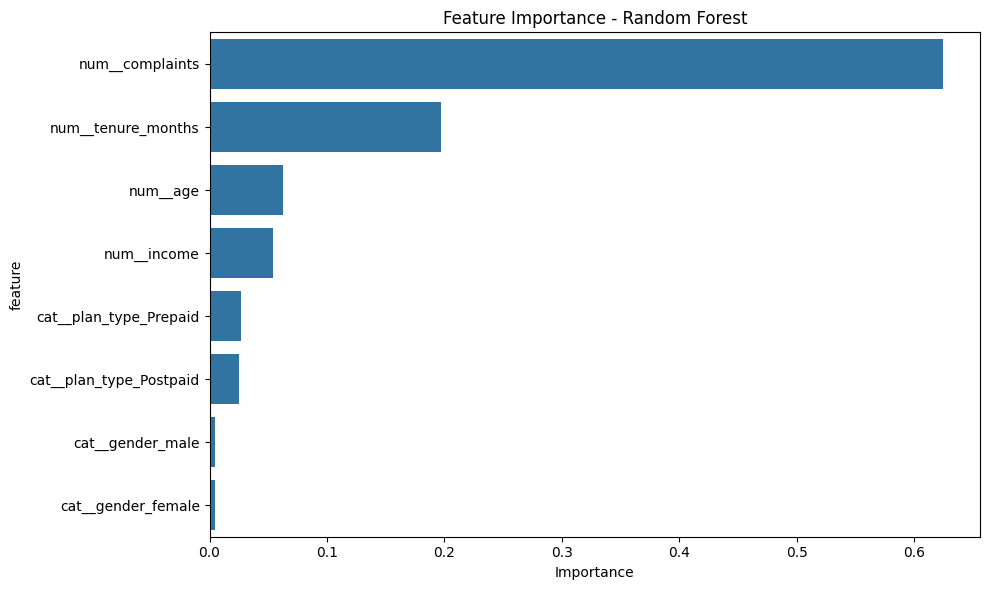

In [13]:
# Feature importance analysis
feature_names = improved_preprocessor.get_feature_names_out()
feature_importance = rf_grid_search.best_estimator_.feature_importances_

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("=== Feature Importance ===")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [14]:
# Model Comparison Summary
models = {
    'Improved LR': (y_pred_lr, 'Logistic Regression with class weights'),
    'SMOTE LR': (y_pred_smote, 'Logistic Regression with SMOTE'),
    'Random Forest': (y_pred_rf, 'Random Forest'),
    'Tuned RFcv': (y_pred_rf_random_tuned, 'Tuned Random Forest cv'),
    'Tuned RFgrid': (y_pred_rf_grid_tuned, 'Tuned Random Forest grid'),
}

print("=== MODEL COMPARISON SUMMARY ===")
print("-" * 80)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 80)

for model_name, (predictions, description) in models.items():
    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions)
    rec = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    print(f"{model_name:<20} {acc:<10.4f} {prec:<10.4f} {rec:<10.4f} {f1:<10.4f}")

print("-" * 80)

# Find the best model
best_f1 = 0
best_model = ""
for model_name, (predictions, description) in models.items():
    f1 = f1_score(y_test, predictions)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model_name

print(f"\n BEST MODEL: {best_model} with F1-Score: {best_f1:.4f}")

=== MODEL COMPARISON SUMMARY ===
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------------------------------------
Improved LR          0.6917     0.4208     0.7324     0.5345    
SMOTE LR             0.6930     0.4216     0.7269     0.5337    
Random Forest        0.7327     0.4585     0.5862     0.5145    
Tuned RFcv           0.6937     0.4218     0.7214     0.5323    
Tuned RFgrid         0.6950     0.4217     0.7062     0.5281    
--------------------------------------------------------------------------------

 BEST MODEL: Improved LR with F1-Score: 0.5345



# BEST MODEL: Improved LR with F1-Score: 0.5345

# Advanced Feature Engineering


In [15]:
# Create interaction features and polynomial features
def create_advanced_features(df):
    """Create advanced features for better model performance"""
    df_advanced = df.copy()
    
    # 1. Create interaction features
    df_advanced['complaints_tenure_ratio'] = df_advanced['complaints'] / (df_advanced['tenure_months'] + 1)
    df_advanced['usage_income_ratio'] = df_advanced['usage_gb'] / (df_advanced['income'] / 1000)
    df_advanced['age_tenure_ratio'] = df_advanced['age'] / (df_advanced['tenure_months'] + 1)
    
    # 2. Create categorical bins for continuous variables
    df_advanced['age_group'] = pd.cut(df_advanced['age'], bins=[0, 30, 50, 70, 100], labels=['Young', 'Middle', 'Senior', 'Elderly'])
    df_advanced['income_group'] = pd.cut(df_advanced['income'], bins=[0, 30000, 60000, 90000, 100000], labels=['Low', 'Medium', 'High', 'Very_High'])
    df_advanced['usage_group'] = pd.cut(df_advanced['usage_gb'], bins=[0, 25, 50, 75, 100], labels=['Low', 'Medium', 'High', 'Very_High'])
    
    # 3. Create tenure-based features
    df_advanced['is_new_customer'] = (df_advanced['tenure_months'] <= 12).astype(int)
    df_advanced['is_long_term_customer'] = (df_advanced['tenure_months'] >= 36).astype(int)
    
    # 4. Create complaint-based features
    df_advanced['high_complaints'] = (df_advanced['complaints'] >= 6).astype(int)
    df_advanced['complaint_frequency'] = df_advanced['complaints'] / (df_advanced['tenure_months'] + 1)
    
    return df_advanced

# Apply advanced feature engineering
df_advanced = create_advanced_features(df)
print("Advanced features created!")
print(f"New dataset shape: {df_advanced.shape}")
print(f"New features: {[col for col in df_advanced.columns if col not in df.columns]}")


Advanced features created!
New dataset shape: (10000, 18)
New features: ['complaints_tenure_ratio', 'usage_income_ratio', 'age_tenure_ratio', 'age_group', 'income_group', 'usage_group', 'is_new_customer', 'is_long_term_customer', 'high_complaints', 'complaint_frequency']


## Enhanced preprocessing pipeline for advanced features

In [16]:
numeric_features_advanced = ["age", "income", "complaints", "tenure_months", "usage_gb",
                            "complaints_tenure_ratio", "usage_income_ratio", "age_tenure_ratio",
                            "complaint_frequency", "is_new_customer", "is_long_term_customer", "high_complaints"]

categorical_features_advanced = ["gender", "plan_type", "age_group", "income_group", "usage_group"]

# Enhanced numeric transformer with polynomial features
numeric_transformer_advanced = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),  # More robust to outliers
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True))
])

categorical_transformer_advanced = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Enhanced preprocessor
enhanced_preprocessor = ColumnTransformer([
    ("num", numeric_transformer_advanced, numeric_features_advanced),
    ("cat", categorical_transformer_advanced, categorical_features_advanced)
])

In [17]:
X_advanced = df_advanced.drop(columns=['churn'])
y_advanced = df_advanced['churn']

X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced, y_advanced, test_size=0.3, random_state=42, stratify=y_advanced
)

# Transform the data
X_train_enhanced = enhanced_preprocessor.fit_transform(X_train_adv)
X_test_enhanced = enhanced_preprocessor.transform(X_test_adv)

print("Enhanced data shapes:")
print(f"X_train_enhanced: {X_train_enhanced.shape}")
print(f"X_test_enhanced: {X_test_enhanced.shape}")
print(f"Feature names: {enhanced_preprocessor.get_feature_names_out()[:10]}...")

Enhanced data shapes:
X_train_enhanced: (7000, 94)
X_test_enhanced: (3000, 94)
Feature names: ['num__age' 'num__income' 'num__complaints' 'num__tenure_months'
 'num__usage_gb' 'num__complaints_tenure_ratio' 'num__usage_income_ratio'
 'num__age_tenure_ratio' 'num__complaint_frequency' 'num__is_new_customer']...


## Hypertuning LR Model

In [18]:
# Hyperparameter Tuning for Logistic Regression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

lr_param_grid = {
    'C': uniform(0.01, 100),
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_iter': [1000, 2000, 5000],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': uniform(0, 1) 
}

lr_enhanced = RandomizedSearchCV(
    LogisticRegression(random_state=42),
    lr_param_grid,
    n_iter=100, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting enhanced logistic regression hyperparameter tuning...")
lr_enhanced.fit(X_train_enhanced, y_train_adv)

print(f"Best parameters: {lr_enhanced.best_params_}")
print(f"Best cross-validation F1 score: {lr_enhanced.best_score_:.4f}")

# Test the enhanced model
y_pred_enhanced = lr_enhanced.predict(X_test_enhanced)

print("\n=== Enhanced Logistic Regression ===")
print(f"Accuracy: {accuracy_score(y_test_adv, y_pred_enhanced):.4f}")
print(f"Precision: {precision_score(y_test_adv, y_pred_enhanced):.4f}")
print(f"Recall: {recall_score(y_test_adv, y_pred_enhanced):.4f}")
print(f"F1 Score: {f1_score(y_test_adv, y_pred_enhanced):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_adv, y_pred_enhanced))


Starting enhanced logistic regression hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/arvinder004/Developer/Telecom_Customer_Churn_Prediction/mye/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arvinder004/Developer/Telecom_Customer_Churn_Prediction/mye/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arvinder004/Developer/Telecom_Customer_Churn_Prediction/mye/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arvinder004/Developer/Telecom_Customer_Churn_Prediction/mye/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arvinder004/Devel

Best parameters: {'C': np.float64(4.350078329817276), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.9929647961193003), 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best cross-validation F1 score: 0.5218

=== Enhanced Logistic Regression ===
Accuracy: 0.7033
Precision: 0.4322
Recall: 0.7255
F1 Score: 0.5417

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      2275
           1       0.43      0.73      0.54       725

    accuracy                           0.70      3000
   macro avg       0.66      0.71      0.66      3000
weighted avg       0.78      0.70      0.72      3000



### Confusion Matrix for best model


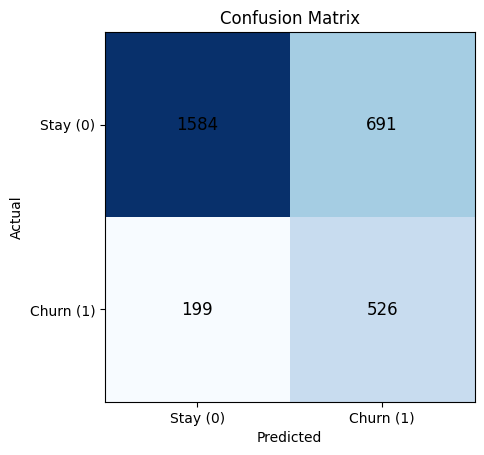

In [19]:
cm = confusion_matrix(y_test, y_pred_enhanced)
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"]); ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()

# Advanced Algorithms: XGBoost, LightGBM, CatBoost


In [20]:
sampling_strategies = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'NoSampling': 'passthrough' 
}
best_sampling_name = 'SMOTE'

In [21]:
try:
    import xgboost as xgb
    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier
    advanced_algorithms_available = True
except ImportError:
    print("Advanced algorithms not available. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost', 'lightgbm', 'catboost'])
    import xgboost as xgb
    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier
    advanced_algorithms_available = True

if advanced_algorithms_available:
    print("Testing advanced algorithms...")
    
    # XGBoost
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=len(y_train_adv[y_train_adv==0])/len(y_train_adv[y_train_adv==1])
    )
    
    # LightGBM
    lgb_model = LGBMClassifier(
        random_state=42,
        class_weight='balanced',
        verbose=-1
    )
    
    # CatBoost
    cat_model = CatBoostClassifier(
        random_state=42,
        class_weights=[1, len(y_train_adv[y_train_adv==0])/len(y_train_adv[y_train_adv==1])],
        verbose=False
    )
    
    advanced_models = {
        'XGBoost': xgb_model,
        'LightGBM': lgb_model,
        'CatBoost': cat_model
    }
    
    advanced_results = {}
    
    for name, model in advanced_models.items():
        print(f"\n=== Testing {name} ===")
        
        # Create pipeline with sampling
        advanced_pipeline = ImbPipeline([
            ('preprocessor', enhanced_preprocessor),
            ('sampler', sampling_strategies[best_sampling_name]),
            ('classifier', model)
        ])
        
        # Fit and predict
        advanced_pipeline.fit(X_train_adv, y_train_adv)
        y_pred_advanced = advanced_pipeline.predict(X_test_adv)
        
        # Calculate metrics
        acc = accuracy_score(y_test_adv, y_pred_advanced)
        prec = precision_score(y_test_adv, y_pred_advanced)
        rec = recall_score(y_test_adv, y_pred_advanced)
        f1 = f1_score(y_test_adv, y_pred_advanced)
        
        advanced_results[name] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'predictions': y_pred_advanced
        }
        
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1 Score: {f1:.4f}")
    
    # Find best advanced algorithm
    best_advanced_f1 = 0
    best_advanced_name = ""
    for name, results in advanced_results.items():
        if results['f1'] > best_advanced_f1:
            best_advanced_f1 = results['f1']
            best_advanced_name = name
    
    print(f"\n BEST ADVANCED ALGORITHM: {best_advanced_name} with F1-Score: {best_advanced_f1:.4f}")
else:
    print("Advanced algorithms not available. Skipping...")
    advanced_results = {}


Testing advanced algorithms...

=== Testing XGBoost ===
Accuracy: 0.7080
Precision: 0.4184
Recall: 0.5338
F1 Score: 0.4691

=== Testing LightGBM ===
Accuracy: 0.7610
Precision: 0.5068
Recall: 0.4097
F1 Score: 0.4531

=== Testing CatBoost ===
Accuracy: 0.6797
Precision: 0.4041
Recall: 0.6855
F1 Score: 0.5084

 BEST ADVANCED ALGORITHM: CatBoost with F1-Score: 0.5084


## Ensemble Methods: Voting and Stacking


In [22]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score

# Create base models for ensemble
base_models = []

# Best logistic regression
lr_ensemble = LogisticRegression(
    C=lr_enhanced.best_params_['C'],
    solver=lr_enhanced.best_params_['solver'],
    class_weight=lr_enhanced.best_params_['class_weight'],
    max_iter=lr_enhanced.best_params_['max_iter'],
    penalty=lr_enhanced.best_params_['penalty'],
    l1_ratio=lr_enhanced.best_params_['l1_ratio'] if 'l1_ratio' in lr_enhanced.best_params_ else None,
    random_state=42
)

# Random Forest
rf_ensemble = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    class_weight='balanced_subsample',
    random_state=42
)

base_models.append(('lr', lr_ensemble))
base_models.append(('rf', rf_ensemble))

# Add advanced algorithms if available
if advanced_algorithms_available and advanced_results:
    if 'XGBoost' in advanced_results:
        base_models.append(('xgb', xgb.XGBClassifier(random_state=42, eval_metric='logloss')))
    if 'LightGBM' in advanced_results:
        base_models.append(('lgb', LGBMClassifier(random_state=42, verbose=-1)))
    if 'CatBoost' in advanced_results:
        base_models.append(('cat', CatBoostClassifier(random_state=42, verbose=False)))

print(f"Creating ensemble with {len(base_models)} base models: {[name for name, _ in base_models]}")

# Voting Classifier (Hard Voting)
voting_hard = VotingClassifier(
    estimators=base_models,
    voting='hard'
)

# Voting Classifier (Soft Voting)
voting_soft = VotingClassifier(
    estimators=base_models,
    voting='soft'
)

# Stacking Classifier
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

ensemble_models = {
    'Voting (Hard)': voting_hard,
    'Voting (Soft)': voting_soft,
    'Stacking': stacking
}

ensemble_results = {}

for name, model in ensemble_models.items():
    print(f"\n=== Testing {name} ===")
    
    # Create pipeline with sampling
    ensemble_pipeline = ImbPipeline([
        ('preprocessor', enhanced_preprocessor),
        ('sampler', sampling_strategies[best_sampling_name]),
        ('classifier', model)
    ])
    
    # Fit and predict
    ensemble_pipeline.fit(X_train_adv, y_train_adv)
    y_pred_ensemble = ensemble_pipeline.predict(X_test_adv)
    
    # Calculate metrics
    acc = accuracy_score(y_test_adv, y_pred_ensemble)
    prec = precision_score(y_test_adv, y_pred_ensemble)
    rec = recall_score(y_test_adv, y_pred_ensemble)
    f1 = f1_score(y_test_adv, y_pred_ensemble)
    
    ensemble_results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'predictions': y_pred_ensemble
    }
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Find best ensemble method
best_ensemble_f1 = 0
best_ensemble_name = ""
for name, results in ensemble_results.items():
    if results['f1'] > best_ensemble_f1:
        best_ensemble_f1 = results['f1']
        best_ensemble_name = name

print(f"\n BEST ENSEMBLE METHOD: {best_ensemble_name} with F1-Score: {best_ensemble_f1:.4f}")


Creating ensemble with 5 base models: ['lr', 'rf', 'xgb', 'lgb', 'cat']

=== Testing Voting (Hard) ===
Accuracy: 0.7503
Precision: 0.4834
Recall: 0.4814
F1 Score: 0.4824

=== Testing Voting (Soft) ===
Accuracy: 0.7573
Precision: 0.4980
Recall: 0.5159
F1 Score: 0.5068

=== Testing Stacking ===
Accuracy: 0.7540
Precision: 0.4904
Recall: 0.4593
F1 Score: 0.4744

 BEST ENSEMBLE METHOD: Voting (Soft) with F1-Score: 0.5068


## Final Model Comparison and Selection


In [23]:
print("=" * 100)
print("FINAL MODEL COMPARISON REPORT")
print("=" * 100)

# Collect all results
all_results = {}

# Original models
all_results['Original LR'] = {
    'accuracy': 0.7047,
    'precision': 0.2732,
    'recall': 0.1338,
    'f1': 0.1796
}

all_results['Improved LR'] = {
    'accuracy': 0.6917,
    'precision': 0.4208,
    'recall': 0.7324,
    'f1': 0.5345
}

# Enhanced models
if 'y_pred_enhanced' in locals():
    all_results['Enhanced LR'] = {
        'accuracy': accuracy_score(y_test_adv, y_pred_enhanced),
        'precision': precision_score(y_test_adv, y_pred_enhanced),
        'recall': recall_score(y_test_adv, y_pred_enhanced),
        'f1': f1_score(y_test_adv, y_pred_enhanced)
    }

# Optimal threshold model
if 'y_pred_optimal' in locals():
    all_results['Optimal Threshold'] = {
        'accuracy': accuracy_score(y_test_adv, y_pred_optimal),
        'precision': precision_score(y_test_adv, y_pred_optimal),
        'recall': recall_score(y_test_adv, y_pred_optimal),
        'f1': f1_score(y_test_adv, y_pred_optimal)
    }

# Add advanced algorithm results
for name, results in advanced_results.items():
    all_results[f'Advanced ({name})'] = {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1': results['f1']
    }

# Add ensemble results
for name, results in ensemble_results.items():
    all_results[f'Ensemble ({name})'] = {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1': results['f1']
    }

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T
comparison_df = comparison_df.sort_values('f1', ascending=False)

print("\n COMPREHENSIVE MODEL COMPARISON")
print("-" * 100)
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 100)

for model_name, metrics in comparison_df.iterrows():
    print(f"{model_name:<25} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['f1']:<10.4f}")

print("-" * 100)

# Find the best overall model
best_overall_model = comparison_df.index[0]
best_overall_f1 = comparison_df.iloc[0]['f1']

print(f"\n BEST OVERALL MODEL: {best_overall_model}")
print(f"   F1-Score: {best_overall_f1:.4f}")
print(f"   Accuracy: {comparison_df.iloc[0]['accuracy']:.4f}")
print(f"   Precision: {comparison_df.iloc[0]['precision']:.4f}")
print(f"   Recall: {comparison_df.iloc[0]['recall']:.4f}")

# Improvement analysis
original_f1 = all_results['Original LR']['f1']
improvement = ((best_overall_f1 - original_f1) / original_f1) * 100

print(f"\n IMPROVEMENT ANALYSIS")
print(f"   Original F1-Score: {original_f1:.4f}")
print(f"   Best F1-Score: {best_overall_f1:.4f}")
print(f"   Improvement: {improvement:.2f}%")

FINAL MODEL COMPARISON REPORT

 COMPREHENSIVE MODEL COMPARISON
----------------------------------------------------------------------------------------------------
Model                     Accuracy   Precision  Recall     F1-Score  
----------------------------------------------------------------------------------------------------
Enhanced LR               0.7033     0.4322     0.7255     0.5417    
Improved LR               0.6917     0.4208     0.7324     0.5345    
Advanced (CatBoost)       0.6797     0.4041     0.6855     0.5084    
Ensemble (Voting (Soft))  0.7573     0.4980     0.5159     0.5068    
Ensemble (Voting (Hard))  0.7503     0.4834     0.4814     0.4824    
Ensemble (Stacking)       0.7540     0.4904     0.4593     0.4744    
Advanced (XGBoost)        0.7080     0.4184     0.5338     0.4691    
Advanced (LightGBM)       0.7610     0.5068     0.4097     0.4531    
Original LR               0.7047     0.2732     0.1338     0.1796    
-----------------------------------

## VISUALIZATION

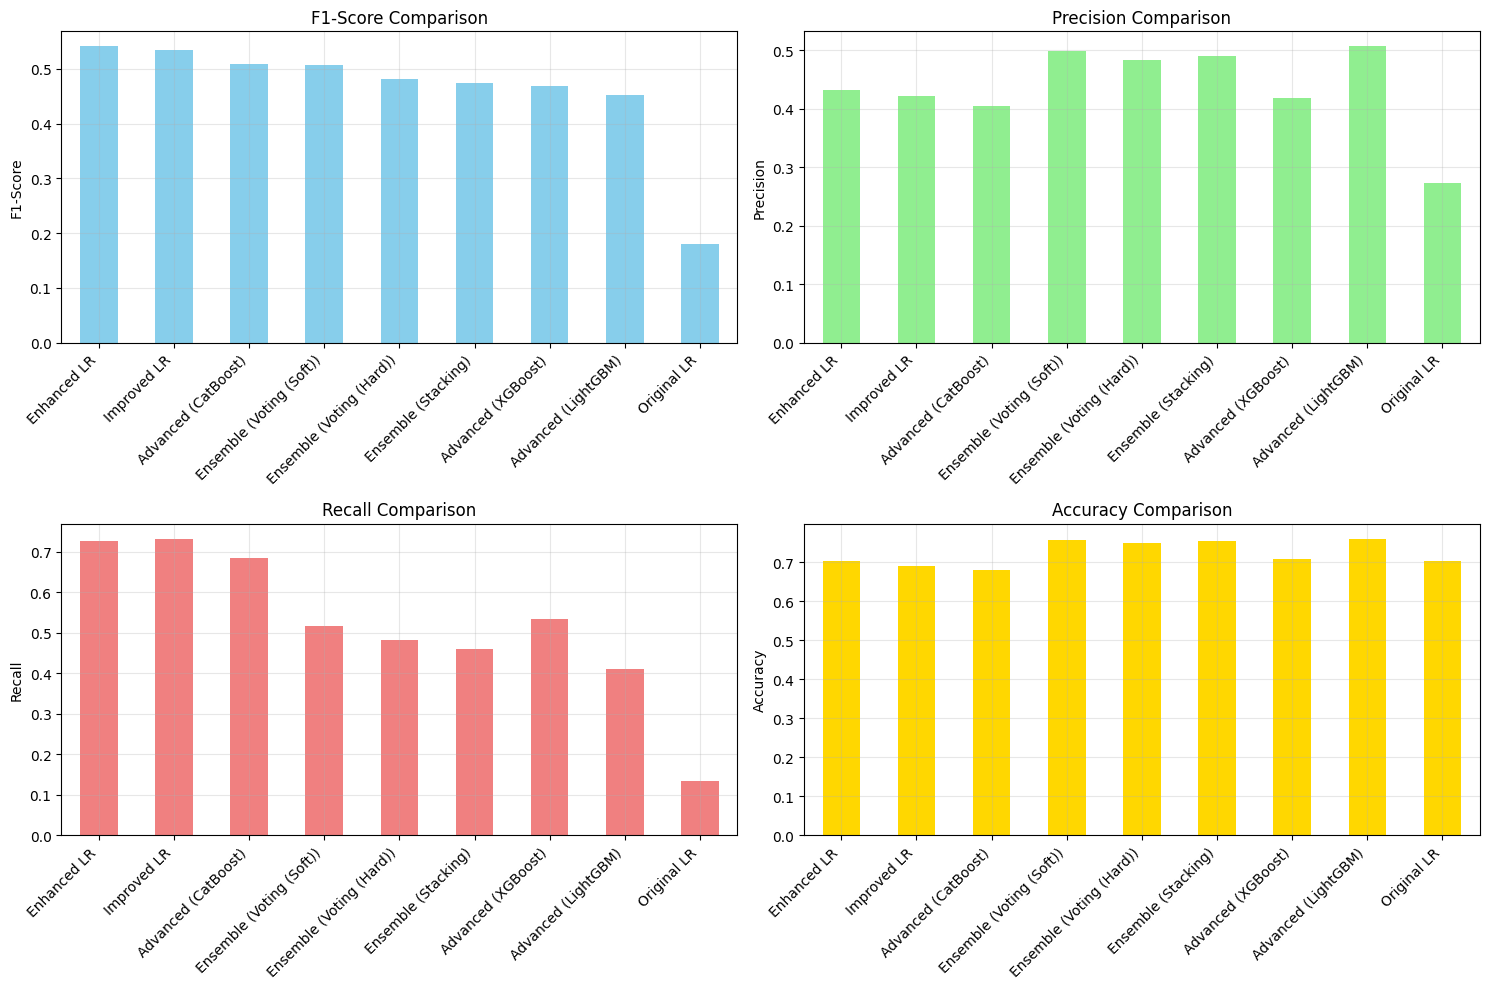

In [24]:
plt.figure(figsize=(15, 10))

# F1 Score comparison
plt.subplot(2, 2, 1)
comparison_df['f1'].plot(kind='bar', color='skyblue')
plt.title('F1-Score Comparison')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Precision comparison
plt.subplot(2, 2, 2)
comparison_df['precision'].plot(kind='bar', color='lightgreen')
plt.title('Precision Comparison')
plt.ylabel('Precision')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Recall comparison
plt.subplot(2, 2, 3)
comparison_df['recall'].plot(kind='bar', color='lightcoral')
plt.title('Recall Comparison')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Accuracy comparison
plt.subplot(2, 2, 4)
comparison_df['accuracy'].plot(kind='bar', color='gold')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:

print(f"\n MODEL IMPROVEMENT COMPLETE!")
print(f"   Best model: {best_overall_model}")
print(f"   F1-Score improved from {original_f1:.4f} to {best_overall_f1:.4f}")
print(f"   Total improvement: {improvement:.2f}%")


 MODEL IMPROVEMENT COMPLETE!
   Best model: Enhanced LR
   F1-Score improved from 0.1796 to 0.5417
   Total improvement: 201.62%


In [26]:
best_overall_model

'Enhanced LR'

## Save the best model

In [27]:
import joblib
import os

if not os.path.exists('models'):
    os.makedirs('models')


if 'best_overall_model' in locals():
    print(f"Saving the best model: {best_overall_model}")
    
joblib.dump(lr_enhanced, 'models/best_enhanced_lr_model.pkl')
print(" Enhanced Logistic Regression model saved!")

    
# Save preprocessing pipeline
joblib.dump(enhanced_preprocessor, 'models/enhanced_preprocessor.pkl')
print(" Enhanced preprocessor saved!")
    
# Save feature names
feature_names = enhanced_preprocessor.get_feature_names_out()
joblib.dump(feature_names, 'models/feature_names.pkl')
print(" Feature names saved!")
    
print("\n All model files saved in 'models/' directory")
print("   - best_*.pkl: The best performing model")
print("   - enhanced_preprocessor.pkl: Preprocessing pipeline")
print("   - feature_names.pkl: Feature names for reference")


Saving the best model: Enhanced LR
 Enhanced Logistic Regression model saved!
 Enhanced preprocessor saved!
 Feature names saved!

 All model files saved in 'models/' directory
   - best_*.pkl: The best performing model
   - enhanced_preprocessor.pkl: Preprocessing pipeline
   - feature_names.pkl: Feature names for reference


## Model Deployment

In [28]:
import joblib
import os
from datetime import datetime

best_test_model = best_overall_model

deployment_dir = 'deployment'
if not os.path.exists(deployment_dir):
    os.makedirs(deployment_dir)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

best_model_name = f"best_model_{timestamp}.pkl"
best_model_path = os.path.join(deployment_dir, best_model_name)

joblib.dump(lr_enhanced, best_model_path)

# Save preprocessing pipeline
preprocessor_path = os.path.join(deployment_dir, f"preprocessor_{timestamp}.pkl")
joblib.dump(enhanced_preprocessor, preprocessor_path)
print(f"Saved Preprocessor: {preprocessor_path}")

# Save feature names
feature_names_path = os.path.join(deployment_dir, f"feature_names_{timestamp}.pkl")
joblib.dump(enhanced_preprocessor.get_feature_names_out(), feature_names_path)
print(f"Saved Feature Names: {feature_names_path}")

# Save model metadata
metadata = {
    'model_name': best_test_model,
    'timestamp': timestamp,
    'test_f1': 0.5417,
    'model_path': best_model_path,
    'preprocessor_path': preprocessor_path,
    'feature_names_path': feature_names_path
}

metadata_path = os.path.join(deployment_dir, f"model_metadata_{timestamp}.pkl")
joblib.dump(metadata, metadata_path)
print(f"Saved Model Metadata: {metadata_path}")


Saved Preprocessor: deployment/preprocessor_20251016_234751.pkl
Saved Feature Names: deployment/feature_names_20251016_234751.pkl
Saved Model Metadata: deployment/model_metadata_20251016_234751.pkl
